<a href="https://colab.research.google.com/github/coustea/StudyHub/blob/Agent/Langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from langchain.tools import tool
from langchain_openai import ChatOpenAI

In [ ]:
OPENAI_API_KEY="sk-414fa005f52f41acb70c615dd2f7cc95"
BASE_URL="https://dashscope.aliyuncs.com/compatible-mode/v1"


In [ ]:
model = ChatOpenAI(
    model="qwen-max",
    api_key=OPENAI_API_KEY,
    base_url=BASE_URL,
)

In [ ]:
# 实现工具
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b

In [ ]:
# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [ ]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

In [ ]:
from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [ ]:
from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [ ]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

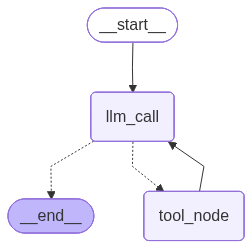

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_939cf8f021c246efb59c35)
 Call ID: call_939cf8f021c246efb59c35
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [ ]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [ ]:
#!pip install -q langchain-community

In [ ]:
#!pip install  google-search-results


In [ ]:
import requests
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent

class WeatherQuery(BaseModel):
    loc: str = Field(description="城市名称")


@tool(args_schema=WeatherQuery)
def get_weather(loc):
    """
        查询即时天气函数
        :param loc: 必要参数，字符串类型，用于表示查询天气的具体城市名称，\
        :return：心知天气 API查询即时天气的结果，具体URL请求地址为："https://api.seniverse.com/v3/weather/now.json"
        返回结果对象类型为解析之后的JSON格式对象，并用字符串形式进行表示，其中包含了全部重要的天气信息
    """
    url = "https://api.seniverse.com/v3/weather/now.json"
    params = {
        "key": "S8f2ySUk1IxDL048u",
        "location": loc,
        "language": "zh-Hans",
        "unit": "c",
    }
    response = requests.get(url, params=params)
    temperature = response.json()
    #print(temperature['results'][0]['now'])
    return temperature['results'][0]['now']

tools = [get_weather]

agent = create_react_agent(model=model, tools=tools)


/tmp/ipython-input-761754161.py:33: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(model=model, tools=tools)


In [ ]:
response = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "长春现在的天气如何?"
            }
        ],
          "recursion_limit": 4
    }
)

# print(response['messages'])
print(response['messages'][-1].content)

长春现在的天气是晴，温度为-19°C，体感温度也是-19°C。气压为998百帕，湿度为63%。风向西，风速4.0公里/小时，风力等级为1级。云量50%，能见度29.9公里。
